# Pydough LLM Demo

This notebook showcases how an LLM can generate PyDough queries from natural language instructions. The goal is to demonstrate how AI can automate complex data analysis, making querying faster, more intuitive, and accessible without needing deep technical expertise.

Each example highlights different capabilities, including aggregations, filtering, ranking, and calculations across multiple collections.

---
## Setup & Basic Usage of the API

First, we import the created client.

In [10]:
from llm_v2 import LLMClient

Then we initialize the client.

In [11]:
client = LLMClient()

One should use the `ask()` method to make a query to the model.

We get a `result` object with the next attributes: 

- `code`:  The PyDough query generated by the LLM.
- `full_explanation`: A detailed explanation of how the query works.
- `df`:The dataframe containing the query results.
- `exception`: Stores any errors encountered while executing the query.
- `original_question`: The natural language question input by the user.
- `sql`: The SQL equivalent of the generated PyDough query.
- `base_prompt`: The initial instruction given to the LLM to generate the query.
- `cheat_sheet`:  A reference guide or example queries to help the LLM structure responses.
- `knowledge_graph`: The metadata structure that informs the LLM about available collections and relationships.

---
## First query

Ask method asks a simple query (no discourse mode)

In [5]:
result = client.ask("Give me all the suppliers name from united states")

suppliers_from_united_states = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(
    supplier_name=name
)


After that, we can consult all the necessary atributes from the result.

Initially, I want to check the **base instruction** that guided the LLM.

In [6]:
print(result.base_prompt)

<task_description>
You are an AI assistant tasked with converting natural language descriptions into PyDough code snippets. Your goal is to generate accurate and efficient PyDough code that can execute the requested database operations based on the provided natural language description. 
</task_description>

<context>
To assist you in this task, you will be provided with the following context:

1. **PyDough Reference File**  
This file contains the core concepts, functions, and syntax of the PyDough language. It serves as a reference for understanding the PyDough syntax and structure.

{script_content}

2. **Database Structure Reference File**  
This file outlines the database schema, collections, fields, and relationships. It provides information about the underlying data structure and organization.

{database_content}

3. **Examples for Context**  
Here are some examples of PyDough code snippets along with their corresponding natural language questions. These examples can help contex

We can also ask for the for the **pydough code** directly.

In [7]:
print(result.code)

suppliers_from_united_states = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(
    supplier_name=name
)


And if we want to compare, we can get the **equivalent SQL query** created by Pydough.

In [8]:
print(result.sql)

SELECT
  name AS supplier_name
FROM (
  SELECT
    s_name AS name,
    s_nationkey AS nation_key
  FROM main.SUPPLIER
)
INNER JOIN (
  SELECT
    key
  FROM (
    SELECT
      n_name AS name,
      n_nationkey AS key
    FROM main.NATION
  )
  WHERE
    name = 'UNITED STATES'
)
  ON nation_key = key


If we want to visually check, analyze or edit the resulting **dataframe**, we also can. There is a dedicated section for this later. on the document

In [9]:
result.df

,supplier_name
0,Supplier#000000010
1,Supplier#000000019
2,Supplier#000000046
3,Supplier#000000049
4,Supplier#000000055
...,...
388,Supplier#000009819
389,Supplier#000009829
390,Supplier#000009859
391,Supplier#000009906


We can also get a simple **explanation** of the query.

In the future, we will offer an English-only explanation to learn more about what the query is about, but for now, you can view a combined PyDough and English explanation generated by the LLM.


In [10]:
print(result.full_explanation)

Okay, let's break this down.

1.  We need to start with the `suppliers` collection.
2.  We need to filter the suppliers to only include those from the "UNITED STATES" nation.
3.  We need to extract the names of the suppliers.

Here's the PyDough code:

```python
suppliers_from_united_states = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(
    supplier_name=name
)
```



We can also check the original natural language **question** that was asked.

In [11]:
print(result.original_question)

Give me all the suppliers name from united states


We also have a reference guide or **cheat_sheet** with example queries to help structure responses.

In [12]:
print(result.cheat_sheet)

## **PYDOUGH CHEAT SHEET**  
This cheat sheet is a context for learning how to create PyDough code. You must follow all the written rules. Each section represents important features and rules to keep in mind when developing PyDough code. 

### **GENERAL RULES**: 

  - This is NOT SQL, so don't make assumptions about its syntax or behavior.

  - Always use TOP_K instead of ORDER_BY when you need to order but also select a the high, low or an specific "k" number of records.

  - If a query does not specify an specific year, and want that you calculate for all the year, for example “compare year over year”, then the requested calculation must be performed for each year available in TPC: 1995, 1996, 1995 and 1998. You need to use SINGULAR function to call every year in the final result. 

  - If you need to use an attribute of a previous collection, you must have calculated the attribute using CALCULATE.

  - New fields defined in a CALCULATE do not take effect until after the CALCULATE co

Now, we will try a new example, this one has an **exception**.

---

## Query correction (early preview)

To try to correct a response with execution problems in PyDough, we can use the `correct()` method. 

NOTE: This method is called whenever the `ask()` method is used and there is an error, using the default flag `is_corrected=False` to avoid loops. So, let's set this flag to True, so that the model tries it only once, and since it is a problematic query, it will probably fail.

In [7]:
result = client.ask("For each of the 5 largest part sizes, find the part of that size with the largest retail price", is_corrected=True)

print(result.full_explanation)

top_5_sizes = parts.CALCULATE(part_size=size, part_retail_price=retail_price).PARTITION(parts, name='part_group', by=(size)).CALCULATE(size=size,part_name=part_group.name, max_price_part=part_group.TOP_K(1, by=retail_price.DESC())).TOP_K(5, by=size.DESC())
Okay, let's break this down into smaller parts.

1.  We need to identify the 5 largest part sizes.
2.  For each of those sizes, we need to find the part with the largest retail price.

Here's the PyDough code I'll generate:

```python
top_5_sizes = parts.CALCULATE(part_size=size, part_retail_price=retail_price).PARTITION(parts, name='part_group', by=(size)).CALCULATE(size=size,part_name=part_group.name, max_price_part=part_group.TOP_K(1, by=retail_price.DESC())).TOP_K(5, by=size.DESC())
```



If one calls the dataframe and gets an error, no response, or a empty dataframe, it is possible that there is a PyDough exception. We can check this by running:

In [8]:
print(result.exception)

Traceback (most recent call last):
  File "/home/gerald8525/repositories/text2pydough/workbench/AAraya/demo/llm_v2.py", line 162, in get_pydough_sql
    result_sql = pydough.to_sql(last_variable)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gerald8525/anaconda3/envs/aisuite_deepseek/lib/python3.12/site-packages/pydough/evaluation/evaluate_unqualified.py", line 130, in to_sql
    qualified: PyDoughQDAG = qualify_node(node, graph, config)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gerald8525/anaconda3/envs/aisuite_deepseek/lib/python3.12/site-packages/pydough/unqualified/qualification.py", line 835, in qualify_node
    return qual.qualify_node(
           ^^^^^^^^^^^^^^^^^^
  File "/home/gerald8525/anaconda3/envs/aisuite_deepseek/lib/python3.12/site-packages/pydough/unqualified/qualification.py", line 792, in qualify_node
    answer = self.qualify_top_k(unqualified, context, is_child)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

You can try to fix the error using the `correct` method. We are going to declare a new variable to obtain the corrected result. 

In [9]:
corrected_result = client.correct(result)

top_5_sizes = parts.CALCULATE(part_size=size, part_retail_price=retail_price).TOP_K(5, by=size.DESC()).CALCULATE(size=size, max_price_part=retail_price).TOP_K(5, by=size.DESC())


To see how the model try to solve the issue, you can print the full explanation of the `corrected_result`.

In [10]:
print(corrected_result.full_explanation)

Okay, I understand the error and the goal. The error "Unrecognized term of simple table collection 'parts' in graph 'TPCH': 'parts'" indicates that you're trying to use the collection `parts` as a term within the `PARTITION` function, which is not allowed. The `by` parameter in `PARTITION` should only contain expressions, not collections. Also, the logic was not correct, you don't need to partition.

Here's the corrected PyDough code:

```python
top_5_sizes = parts.CALCULATE(part_size=size, part_retail_price=retail_price).TOP_K(5, by=size.DESC()).CALCULATE(size=size, max_price_part=retail_price).TOP_K(5, by=size.DESC())
```

Explanation:

1.  **`parts.CALCULATE(part_size=size, part_retail_price=retail_price)`**: This line selects the `parts` collection and creates new fields `part_size` and `part_retail_price` to store the size and retail price of each part.
2.  **`.TOP_K(5, by=size.DESC())`**: This selects the top 5 parts based on their `size` in descending order.
3.  **`.CALCULATE(si

---
## Post-processing dataframe

Once the DataFrame is generated, it can be analysed or manipulated just like any other dataframe, using **any** Python package for analysis, visualization, or transformation. 

This is a planned future feature, and one of the core differentiators of PyDough!

As a first example, in this section we manipulate a resulting dataframe with pandas and matplotlib to create a histogram and a boxplot of the different orders prices.

In [13]:
result = client.ask("Give me all the order prices, name the column total_price.")

result.df

order_prices = orders.CALCULATE(total_price=total_price)


,total_price
0,173665.47
1,46929.18
2,193846.25
3,32151.78
4,144659.20
...,...
1499995,114856.68
1499996,68906.56
1499997,92750.90
1499998,63216.65


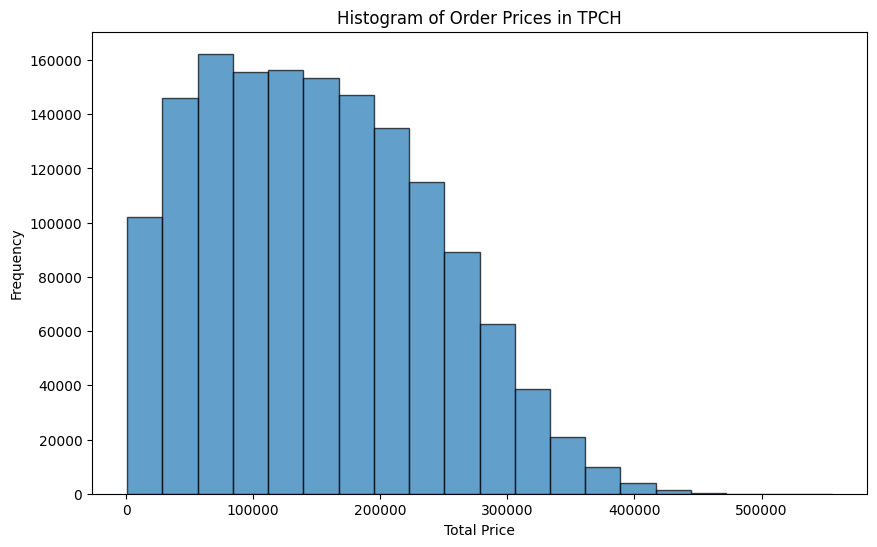

In [14]:
import matplotlib.pyplot as plt

df= result.df

plt.figure(figsize=(10, 6))
plt.hist(df["total_price"], bins=20, edgecolor="black", alpha=0.7)

# Configurar etiquetas y título
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.title("Histogram of Order Prices in TPCH")

# Mostrar el gráfico
plt.show()

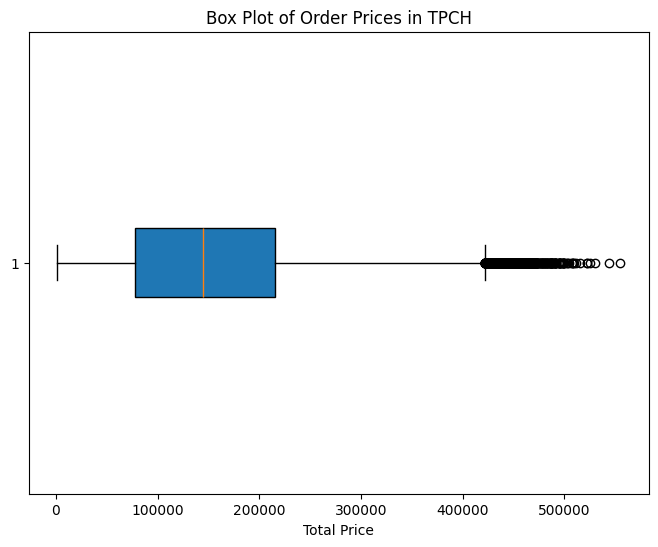

In [15]:
# Create a box plot for order prices
plt.figure(figsize=(8, 6))
plt.boxplot(df["total_price"], vert=False, patch_artist=True)

# Configure labels and title
plt.xlabel("Total Price")
plt.title("Box Plot of Order Prices in TPCH")

# Show the plot
plt.show()

---
## Query Quality and Verification

In the future we will be able to take the PyDough code, the user question, the knowledge graph and the generated data frame to perform semantic tests that will help assure the quality of the results. Some ideas that are under evaluation: 

1. John's graph reconstruction / deconstruction / verification ideas
2. LLM based rules that allow us to confirm certain properties of the Data Frame
   a. If the user requires a top 5 result, then the resulting DF must have 5 rows.
3. Program slicing ideas:
   b. If each cell can be traced to a transformation, look at the transformation and match it against the query (this is connected to John's ideas)
4. Emsemble ideas many variations prompts and LLMs could help us compare multiple results.
5. Talk about why Greg is flabbergasted. 

Here we show a simple demonstration of taking the resulting PyDough code, and then generating structured data from it so that you can compare the variables it used, against the original variables in our Knowledge Graph.

In [16]:
import ast
import json
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

class DSLGraphBuilder:
    class VariableNameExtractor(ast.NodeVisitor):
        def __init__(self):
            self.names = set()
        def visit_Name(self, node):
            # Ignore uppercase identifiers (like COUNT or YEAR)
            if not node.id.isupper():
                self.names.add(node.id)
            self.generic_visit(node)
    
    @staticmethod
    def extract_calculate_rhs_names(code):
        """
        Parse a DSL snippet and extract variable names from the right-hand side 
        of CALCULATE keyword assignments.
        """
        tree = ast.parse(code)
        names = set()
        for node in ast.walk(tree):
            if (
                isinstance(node, ast.Call)
                and isinstance(node.func, ast.Attribute)
                and node.func.attr == "CALCULATE"
            ):
                for kw in node.keywords:
                    extractor = DSLGraphBuilder.VariableNameExtractor()
                    extractor.visit(kw.value)
                    names.update(extractor.names)
        return names
    
    @classmethod
    def build_graph_from_snippets(cls, snippets):
        """
        Build a co-occurrence graph where each variable (from CALCULATE calls) 
        is a node, and an edge connects any two variables that appear together in a snippet.
        """
        all_nodes = set()
        snippet_vars = []  # list of sets of variable names per snippet
        for code in snippets:
            vars_in_snippet = cls.extract_calculate_rhs_names(code)
            snippet_vars.append(vars_in_snippet)
            all_nodes.update(vars_in_snippet)
        
        nodes = [{"id": var, "label": var} for var in sorted(all_nodes)]
        edges = []
        added_edges = set()
        for vars_in_snippet in snippet_vars:
            for a, b in combinations(sorted(vars_in_snippet), 2):
                key = tuple(sorted((a, b)))
                if key not in added_edges:
                    added_edges.add(key)
                    edges.append({"source": key[0], "target": key[1]})
        return {"nodes": nodes, "edges": edges}
    
    @staticmethod
    def visualize_graph(graph):
        """
        Visualize the graph using NetworkX and Matplotlib.
        """
        G = nx.Graph()
        for node in graph["nodes"]:
            G.add_node(node["id"])
        for edge in graph["edges"]:
            G.add_edge(edge["source"], edge["target"])
        
        # Use spring layout for a visually appealing graph
        pos = nx.spring_layout(G)
        
        plt.figure(figsize=(8, 6))
        nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue", edgecolors="black")
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos, font_size=10)
        
        plt.title("Co-occurrence Graph of Variables", fontsize=14)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

Now, this can be used to analyse the PyDough code that was first generated.

{
    "nodes": [
        {
            "id": "acctbal",
            "label": "acctbal"
        },
        {
            "id": "name",
            "label": "name"
        },
        {
            "id": "order_date",
            "label": "order_date"
        },
        {
            "id": "orders",
            "label": "orders"
        }
    ],
    "edges": [
        {
            "source": "acctbal",
            "target": "name"
        },
        {
            "source": "acctbal",
            "target": "order_date"
        },
        {
            "source": "acctbal",
            "target": "orders"
        },
        {
            "source": "name",
            "target": "order_date"
        },
        {
            "source": "name",
            "target": "orders"
        },
        {
            "source": "order_date",
            "target": "orders"
        }
    ]
}


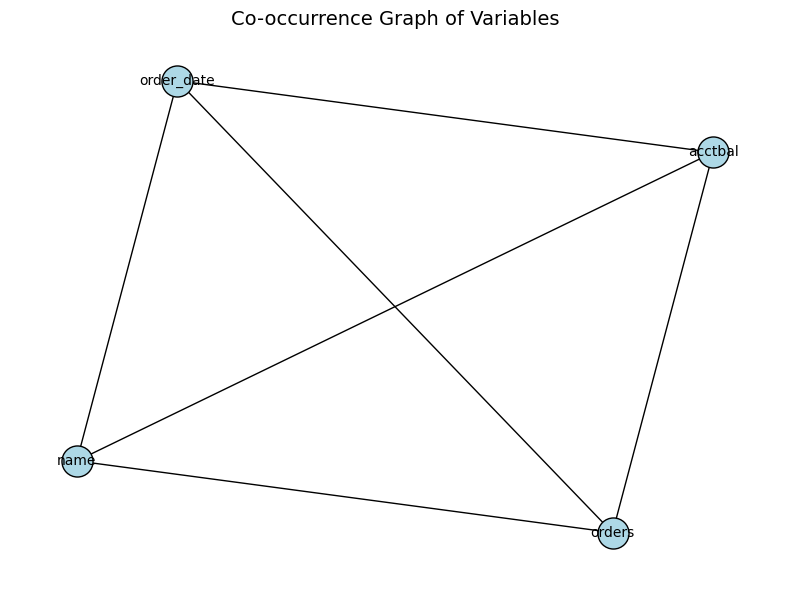

In [17]:
# Using the DSLGraphBuilder defined in a previous cell
builder = DSLGraphBuilder()

# Define your DSL code snippets to analyse

snippet1 = '''# Find all suppliers from the United States
us_suppliers = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(
    supplier_name=name
)
'''
snippet2 = '''# Identify orders in 1995
orders_1995 = orders.WHERE(YEAR(order_date) == 1995)
european_customers = customers.CALCULATE(
    customer_name=name,
    account_balance=acctbal,
    num_orders_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE(
    (nation.region.name == "EUROPE") &
    (acctbal > 700) &
    (num_orders_1995 > 0)
)
'''

snippets = [snippet1, snippet2]

# Build the graph structure from your snippets
graph = builder.build_graph_from_snippets(snippets)

# Print out the graph JSON structure if desired
import json
print(json.dumps(graph, indent=4))

# Visualize the graph using matplotlib and networkx
builder.visualize_graph(graph)


---
That generates a graphical view of the variables, and the co-occurence, and a json with that information, which can be compared against the original json knowledge graph for verification.

NB: This is only a first exploratory step, but as we have better ideas on verification, we will be able to add and extend this segment. Which is why it's an entire workstream as planned in our roadmap.

Now, on to more test cases!

---

## Test Cases

Let's now look at a few more test cases and see how PyDough and PyDough LLM does.

### Customer Segmentation

### 1. Find the names of all customers and the number of orders placed in 1995 in Europe.

- Demonstrates simple filtering, counting, and sorting while being business-relevant for regional market analysis. 
- Adds a second filtering layer by including account balance and order activity, making it more dynamic.

In [12]:
query = "Find the names of all customers and the number of orders placed in 1995 in Europe."

result = client.ask(query)

print(result.full_explanation)
result.df.head()

customer_order_counts = customers.CALCULATE(
    cust_name=name,
    num_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE(nation.region.name == "EUROPE")
Okay, let's break this down into smaller parts.

1.  We need to access the `customers` collection.
2.  We need to filter customers that are in Europe.
3.  We need to count the number of orders placed by each customer in 1995.
4.  We need to return the customer's name and the number of orders.

Here's the PyDough code:

```python
customer_order_counts = customers.CALCULATE(
    cust_name=name,
    num_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE(nation.region.name == "EUROPE")
```



,cust_name,num_orders
0,Customer#000000011,1
1,Customer#000000015,0
2,Customer#000000018,0
3,Customer#000000020,3
4,Customer#000000026,2


**Follow up**: Now, give me the ones who have an account balance greater than $700 and placed at least one order in that same year. Sorted in descending order by the number of orders.

In [13]:
result2 = client.discourse(result, 
"""Now, give me the ones who have an account balance greater than $700 and placed at least one order in that same year. 
Sorted in descending order by the number of orders.""")

print(result2.full_explanation)
result2.df.head()

customer_order_counts = customers.CALCULATE(
    cust_name=name,
    num_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE((nation.region.name == "EUROPE") & (acctbal > 700) & (COUNT(orders.WHERE(YEAR(order_date) == 1995)) > 0)).ORDER_BY(num_orders.DESC())
```python
customer_order_counts = customers.CALCULATE(
    cust_name=name,
    num_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE((nation.region.name == "EUROPE") & (acctbal > 700) & (COUNT(orders.WHERE(YEAR(order_date) == 1995)) > 0)).ORDER_BY(num_orders.DESC())
```


,cust_name,num_orders
0,Customer#000107440,12
1,Customer#000014920,11
2,Customer#000079606,11
3,Customer#000108496,11
4,Customer#000009019,10


### 2. List customers who ordered in 1996 but not in 1997, with a total spent of over 1000$?

- Showcases PyDough’s HAS() and HASNOT() functions, helping analyze customer retention and spending patterns. 
- Also incorporates a time-based calculation.

In [21]:
query = "List customers who ordered in 1996 but not in 1997 with a total spent of over 1000$. If you use HAS add a ==1. Return the customer name and the total spent in 1996"

result = client.ask(query)

print(result.full_explanation)
result.df.head()

customers_1996 = customers.CALCULATE(
    customer_name = name,
    total_spent_1996 = SUM(orders.WHERE(YEAR(order_date) == 1996).total_price)
).WHERE(
    (total_spent_1996 > 1000) & (HASNOT(orders.WHERE(YEAR(order_date) == 1997))==1)
)
Okay, let's break this down into smaller parts.

1.  **Identify customers who ordered in 1996:** We need to filter the `orders` collection for the year 1996 and link it to the `customers` collection.
2.  **Identify customers who did NOT order in 1997:** We need to filter the `orders` collection for the year 1997 and check that the customer does not appear in this collection.
3.  **Total spent over 1000$:** We need to calculate the total spent by each customer in 1996 and filter for those with a total spent greater than 1000.
4.  **Return customer name and total spent in 1996:** Finally, we need to select the customer's name and their total spending in 1996.

Here's the PyDough code:

```python
customers_1996 = customers.CALCULATE(
    customer_name = n

,customer_name,total_spent_1996
0,Customer#000000005,98790.79
1,Customer#000000017,481076.02
2,Customer#000000020,538764.56
3,Customer#000000031,720459.29
4,Customer#000000038,788657.01


**Follow up**: Include the number of months since the last order and sort by total spent, highest first.

In [22]:
result2 = client.discourse(result,
"Now, include the number of months since the last order and sort by total spent, highest first.")

print(result2.full_explanation)
result2.df.head()

customers_1996 = customers.CALCULATE(
    customer_name = name,
    total_spent_1996 = SUM(orders.WHERE(YEAR(order_date) == 1996).total_price),
    last_order_date = MAX(orders.order_date)
).WHERE(
    (total_spent_1996 > 1000) & (HASNOT(orders.WHERE(YEAR(order_date) == 1997))==1)
).CALCULATE(
    months_since_last_order = DATEDIFF("months", last_order_date, DATETIME('now'))
).ORDER_BY(total_spent_1996.DESC())
Okay, I will add the number of months since the last order and sort the results by total spent in 1996, highest first.

Here's the updated PyDough code:

```python
customers_1996 = customers.CALCULATE(
    customer_name = name,
    total_spent_1996 = SUM(orders.WHERE(YEAR(order_date) == 1996).total_price),
    last_order_date = MAX(orders.order_date)
).WHERE(
    (total_spent_1996 > 1000) & (HASNOT(orders.WHERE(YEAR(order_date) == 1997))==1)
).CALCULATE(
    months_since_last_order = DATEDIFF("months", last_order_date, DATETIME('now'))
).ORDER_BY(total_spent_1996.DESC())
```

Exp

,months_since_last_order
0,321
1,320
2,319
3,322
4,320


### Sales Performance

### 3. Find the region name with the highest total order value in 1996.

- The total order value is defined as potential revenue, defined as the sum of extended_price * (1 - discount)
- It introduces precise calculations within the query, ensuring revenue insights.

In [15]:
query = """Find the region name with the highest total order value in 1996. Total order value = (SUM(extended_price * (1 - discount)))."""

result = client.ask(query)

print(result.full_explanation)
result.df.head()

region_order_values_1996 = regions.CALCULATE(
    region_name=name,
    total_order_value=SUM(nations.customers.orders.WHERE(YEAR(order_date) == 1996).lines.CALCULATE(line_total = extended_price * (1 - discount)).line_total)
).TOP_K(1, by=total_order_value.DESC())
Okay, let's break this down into smaller parts.

1.  **Calculate the total order value for each line item:**  This involves calculating `extended_price * (1 - discount)` for each line.
2.  **Calculate the total order value for each order in 1996:**  This involves summing the line item values for each order placed in 1996.
3.  **Calculate the total order value for each nation:**  This involves summing the order values for all orders placed by customers in each nation.
4.  **Calculate the total order value for each region:**  This involves summing the nation values for all nations in each region.
5.  **Find the region with the highest total order value:**  This involves finding the maximum total order value among all regions.



,region_name,total_order_value
0,EUROPE,6.746079e+09


**Follow up**: Can you compare it now year over year?

In [17]:
result2 = client.discourse(result, "Can you compare the total order value year over year in Europe?")

print(result2.full_explanation)
result2.df.head()

europe_order_values_1995 = regions.WHERE(name == "EUROPE").CALCULATE(
    region_name=name,
    total_order_value=SUM(nations.customers.orders.WHERE(YEAR(order_date) == 1995).lines.CALCULATE(line_total = extended_price * (1 - discount)).line_total)
)

europe_order_values_1996 = regions.WHERE(name == "EUROPE").CALCULATE(
    region_name=name,
    total_order_value=SUM(nations.customers.orders.WHERE(YEAR(order_date) == 1996).lines.CALCULATE(line_total = extended_price * (1 - discount)).line_total)
)

europe_order_values_1997 = regions.WHERE(name == "EUROPE").CALCULATE(
    region_name=name,
    total_order_value=SUM(nations.customers.orders.WHERE(YEAR(order_date) == 1997).lines.CALCULATE(line_total = extended_price * (1 - discount)).line_total)
)

europe_order_values_1998 = regions.WHERE(name == "EUROPE").CALCULATE(
    region_name=name,
    total_order_value=SUM(nations.customers.orders.WHERE(YEAR(order_date) == 1998).lines.CALCULATE(line_total = extended_price * (1 - discount)).line_to

,year_1995,year_1996,year_1997,year_1998
0,6.701964e+09,6.746079e+09,6.612330e+09,3.955201e+09


### Product Trends

### 4. Which 10 customers purchased the highest quantity of products during 1998?

Highlights ranking queries (TOP_K()), customer segmentation, and purchasing trends. 

In [24]:
query = "Which 10 customers purchased the highest quantity of products during 1998?. Return the customer name and total quantity."

result = client.ask(query)

print(result.full_explanation)
result.df

customer_quantities = customers.CALCULATE(
    customer_name=name,
    total_quantity=SUM(orders.WHERE(YEAR(order_date) == 1998).lines.quantity)
).TOP_K(10, by=total_quantity.DESC())
Okay, let's break this down. We need to find the top 10 customers who purchased the highest quantity of products in 1998. This will involve the following steps:

1.  Filter the `orders` collection to only include orders from 1998.
2.  Access the `lines` sub-collection for each order to get the quantity of each product purchased.
3.  Sum the quantities for each order.
4.  Associate each order with the customer who placed it.
5.  Sum the total quantities for each customer.
6.  Select the top 10 customers based on the total quantity.
7.  Return the customer name and total quantity.

Here's the PyDough code:

```python
customer_quantities = customers.CALCULATE(
    customer_name=name,
    total_quantity=SUM(orders.WHERE(YEAR(order_date) == 1998).lines.quantity)
).TOP_K(10, by=total_quantity.DESC())
```



,customer_name,total_quantity
0,Customer#000119539,1206
1,Customer#000026518,1158
2,Customer#000024877,1104
3,Customer#000000019,1084
4,Customer#000106000,1058
5,Customer#000102295,1029
6,Customer#000027970,995
7,Customer#000053383,994
8,Customer#000099025,988
9,Customer#000137437,987


**Follow up**: Now only the ones that have "green" on the product name.

In [25]:
result2 = client.discourse(result, "Return the ones that have 'green' on the product name.")

print(result2.full_explanation)
result2.df

customer_quantities = customers.CALCULATE(
    customer_name=name,
    total_quantity=SUM(orders.WHERE(YEAR(order_date) == 1998).lines.WHERE(CONTAINS(part.name, 'green')).quantity)
).TOP_K(10, by=total_quantity.DESC())
Okay, I will refine the previous query to include the additional filtering requirement: "Return the ones that have 'green' on the product name."

Here's the breakdown:

1.  **Base Query:** Start with the previous query that identifies the top 10 customers by the quantity of products purchased in 1998.
2.  **Filter by Product Name:** Add a filter to only include customers who purchased products with "green" in the product name. This requires accessing the `parts` collection through the `lines` collection.

Here's the updated PyDough code:

```python
customer_quantities = customers.CALCULATE(
    customer_name=name,
    total_quantity=SUM(orders.WHERE(YEAR(order_date) == 1998).lines.WHERE(CONTAINS(part.name, 'green')).quantity)
).TOP_K(10, by=total_quantity.DESC())
```

Ex

,customer_name,total_quantity
0,Customer#000011509,208
1,Customer#000022147,201
2,Customer#000027577,201
3,Customer#000109117,176
4,Customer#000016252,172
5,Customer#000009139,171
6,Customer#000099187,170
7,Customer#000024817,164
8,Customer#000112678,162
9,Customer#000072490,158


### Revenue Performance (WIP)

### 5. What is the february 1996 SPM for the almond antique blue royal burnished part in China?

- SPM (Selling Profit Margin) = (Total Amount from Sells - (Tax + Commission)) / Total Amount from Sells * 100
- This query was provided as a representative example of potential stakeholder inquiries.
- Showcases advanced partitioning and filtering, demonstrating how PyDough can be used for highly specific business KPIs. 
- Compare with a previous time period and exclude/include specific suppliers, making it a progressive data exploration example.

In [14]:
query = """What is the february 1996 SPM for the part called 'rosy black navajo cream sky'  in China? SPM (Selling Profit Margin) = (Total Amount from Sells - (Tax + Commission)) / Total Amount from Sells * 100. Use the order date as filter"""

result = client.ask(query)

print(result.full_explanation)
result.df

china_sales = lines.WHERE(
    (part.name == 'rosy black navajo cream sky') &
    (YEAR(order.order_date) == 1996) &
    (MONTH(order.order_date) == 2) &
    (supplier.nation.name == 'CHINA')
).CALCULATE(
    total_amount=extended_price * quantity,
    tax_amount=tax,
    commission=extended_price * discount
)

spm = china_sales.CALCULATE(
    selling_profit_margin=(total_amount - (tax_amount + commission)) / total_amount * 100
)
```python
china_sales = lines.WHERE(
    (part.name == 'rosy black navajo cream sky') &
    (YEAR(order.order_date) == 1996) &
    (MONTH(order.order_date) == 2) &
    (supplier.nation.name == 'CHINA')
).CALCULATE(
    total_amount=extended_price * quantity,
    tax_amount=tax,
    commission=extended_price * discount
)

spm = china_sales.CALCULATE(
    selling_profit_margin=(total_amount - (tax_amount + commission)) / total_amount * 100
)
```


,selling_profit_margin
0,99.722213


**Follow up**: Compare that to november 1995 SPM, have we seen an increase?

In [9]:
result2 = client.discourse(result, "Also calculate november 1995 SPM, and return 1995 and 1996 to compare it.")

print(result2.full_explanation)
result2.df

china_sales_1995_11 = lines.WHERE(
    (part.name == 'rosy black navajo cream sky') &
    (YEAR(order.order_date) == 1995) &
    (MONTH(order.order_date) == 11) &
    (supplier.nation.name == 'CHINA')
).CALCULATE(
    total_amount=extended_price * quantity,
    tax_amount=tax,
    commission=extended_price * discount
)

spm_1995_11 = china_sales_1995_11.CALCULATE(
    selling_profit_margin=((total_amount - (tax_amount + commission)) / total_amount) * 100
).SINGULAR().selling_profit_margin

china_sales_1996_02 = lines.WHERE(
    (part.name == 'rosy black navajo cream sky') &
    (YEAR(order.order_date) == 1996) &
    (MONTH(order.order_date) == 2) &
    (supplier.nation.name == 'CHINA')
).CALCULATE(
    total_amount=extended_price * quantity,
    tax_amount=tax,
    commission=extended_price * discount
)

spm_1996_02 = china_sales_1996_02.CALCULATE(
    selling_profit_margin=((total_amount - (tax_amount + commission)) / total_amount) * 100
).SINGULAR().selling_profit_margin

result = TP

,spm_1995,spm_1996
